# SVM: Support Vector Machine

    Not linear classification algorithm

Imports

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import stats
from sklearn import model_selection
from sklearn import svm

## Generate Data set

Generator took from [here](https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5)

In [2]:
N = 500

# Generate points
theta = np.sqrt(np.random.rand(N))*2*np.pi # np.linspace(0,2*pi,100)

r_a = 2*theta + np.pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - np.pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)


# Save DS File
ds = pd.DataFrame(columns=['x', 'y', 'label'], data=res)
# np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

Plot DS

In [3]:

# plt.rcParams["figure.figsize"] = (10, 10)
# plt.scatter(x_a[:,0],x_a[:,1])
# plt.scatter(x_b[:,0],x_b[:,1])
# plt.show()

Split data (train x test)

In [3]:

# Set parameters
class1 = 1
class2 = 0

isReproduceble = True
randomState = 100 if isReproduceble else None

features = ds[ ['x', 'y'] ]
labels = ds['label']
testSize = .4

# Split data
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(features, labels, test_size=testSize, random_state=randomState)

# Test DF
rows = xTest.shape[0]
cols = xTest.shape[1] + 1
testDF = np.zeros( (rows, cols) )
testDF[:, 0:2] = xTest
testDF[:, -1] = yTest
testDF = pd.DataFrame(data=testDF, columns=['x', 'y', 'label'])

# Train DF
rows = xTrain.shape[0]
cols = xTrain.shape[1] + 1
trainDF = np.zeros( (rows, cols) )
trainDF[:, 0:2] = xTrain
trainDF[:, -1] = yTrain
trainDF = pd.DataFrame(data=trainDF, columns=['x', 'y', 'label'])


## Train

##### Graph utils

In [9]:

def plotOne(a: plt.subplot2grid, x: np.array, y: np.array, title = 'svm', color = 'w', marker = '.', label = '') -> None:
    a.scatter(x, y, color=color, marker=marker, label=label)
    a.set_title(title)
    a.legend(loc='lower left')


def getGridFigure(title: str, nCols = 1, nRows = 1, colHeight = 6, colWidth = 7) -> plt.figure:
    figure = plt.figure(figsize=(colWidth*nCols, colHeight*nRows))
    figure.suptitle(title)
    return figure

def plotTraining(approxY: np.array, figure: plt.figure, plotTitle = '', gridShape = (1, 1), row = 0, col = 0) -> plt.axes:
    
    accuracy = np.sum(approxY == yTest) / yTest.shape[0]
    accuracyTxt = 'Accuracy: {:.4f} %'.format(100*accuracy)

    # Plot training points
    a = plt.subplot2grid(gridShape, (row, col), fig=figure)
    c1Points = trainDF[ trainDF['label'] == class1 ]
    c2Points = trainDF[ trainDF['label'] == class2 ]

    plotOne(a=a, x=c1Points['x'].values, y=c1Points['y'].values, title=plotTitle, color='c', label=accuracyTxt)
    plotOne(a=a, x=c2Points['x'].values, y=c2Points['y'].values, title=plotTitle, color='w')

    # Plot valid test points
    validPoints = testDF[testDF['label'] == approxY]
    validC1 = validPoints[ validPoints['label'] == class1 ]
    validC2 = validPoints[ validPoints['label'] == class2 ]

    plotOne(a=a, x=validC1['x'].values, y=validC1['y'].values, title=plotTitle, color='b', marker='*')
    plotOne(a=a, x=validC2['x'].values, y=validC2['y'].values, title=plotTitle, color='y', marker='*')

    # Plot invalid test points
    invalidPoints = testDF[testDF['label'] != approxY]
    invalidC1 = invalidPoints[ invalidPoints['label'] == class1 ]
    invalidC2 = invalidPoints[ invalidPoints['label'] == class2 ]

    plotOne(a=a, x=invalidC1['x'].values, y=invalidC1['y'].values, title=plotTitle, color='r', marker='X')
    plotOne(a=a, x=invalidC2['x'].values, y=invalidC2['y'].values, title=plotTitle, color='m', marker='X')

    return a

### Parameters Selection

Here we simulate the classification for many parameters configurations. Every simulation is visualized through a graph.

- The graphs have the _class 01_ training samples as light `blue dots`;
- The class 02 training samples as `white dots`;
- _Class 01 correctly predicted_ test samples as `blue circles`;
- _Class 02 correctly predicted_ test samples as `yellow circles`;
- _Class 01 wrongly predicted_ test samples as `red crosses`;
- _Class 02 wrongly predicted_ test samples as `pink crosses`;

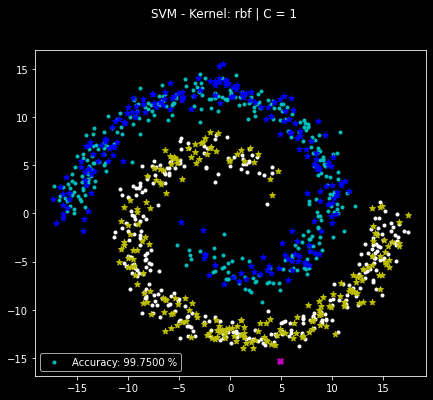

In [8]:
# Svm params
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cValues = [1, 2, 3, 5, 8]

pDegrees = [2] # For degrees greater than 02 the process takes a HUGH time...
pDegreeKenels = ['poly']

gammaValues = [.5, 1, 1.5, 3, 5] # ['scale', 'auto']
gammaKernels = ['poly', 'rbf', 'sigmoid']

# Plot simulations
for kernel in kernels:
    
    isUsingPDegree = kernel in pDegreeKenels
    pDegreesToTest = pDegrees if isUsingPDegree else [1]

    isUsingGamma = kernel in gammaKernels
    gammasToTest = gammaValues if isUsingGamma else [1]

    nRows = len(pDegreesToTest)
    nCols = len(gammasToTest)
    gridShape = (nRows, nCols)
    
    for c in cValues:
        figure = getGridFigure(title='SVM - Kernel: ' + str(kernel) + ' | C = ' + str(c), nCols=nCols, nRows=nRows)
        
        for row, pDegree in enumerate(pDegreesToTest):
            for col, gamma in enumerate(gammasToTest):
                
                classifier = svm.SVC(C=c, kernel=kernel, degree=pDegree, gamma=gamma)
                classifier.fit(trainDF[ ['x', 'y'] ], trainDF['label'])
                
                plotTitle1 = 'pDegree = ' + str(pDegree) if isUsingPDegree else ''
                plotTitle2 = 'gamma = ' + str(gamma) if isUsingGamma else ''
                plotTitle = plotTitle1+ ' | ' +plotTitle2 if (plotTitle1 and plotTitle2) else plotTitle1+plotTitle2
                plotTraining(approxY=classifier.predict(xTest), figure=figure, gridShape=gridShape, row=row, col=col)

        plt.savefig('./file/out_graph-svm-kernel-'+ str(kernel) + '-c=' + str(c))

### Evaluate results

As by the experiments made on the earlier step we found out the best kernel to be __RBF__.

> $K(x_i, x_j) = exp( -\gamma ||x_i - x_j||)^2 )$


- The RBF Kernel function takes the $\gamma$ which tweaks how rigid the margin determination should be;
- By the observation done before we see that lower values of $\gamma$ _(up to $2$)_ fit better for this problem;
- So we're going with $\gamma == 1$

In [6]:
classifier = svm.SVC(kernel='rbf', gamma=1)
classifier.fit(trainDF[ ['x', 'y'] ], trainDF['label'])
approxY = classifier.predict(xTest)

#### Separation Margin

/home/hjcosta/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


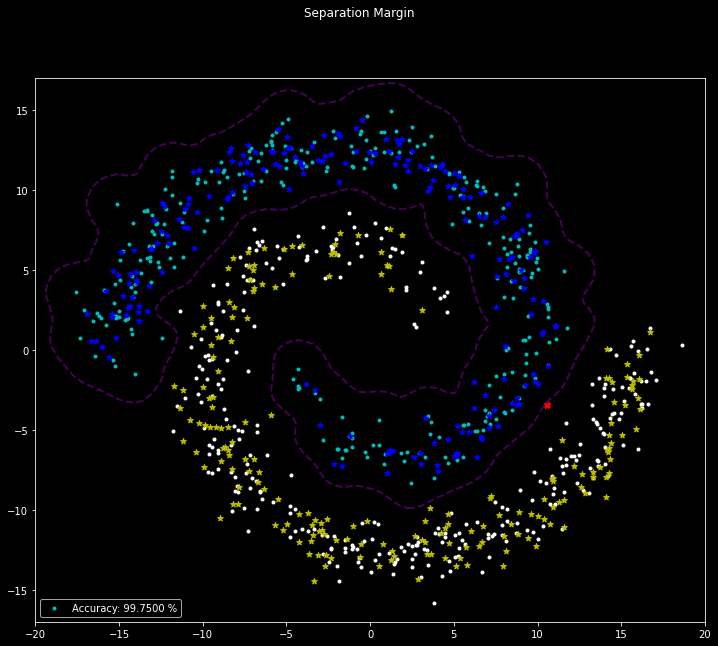

In [25]:

# Build Separation Margin
nPoints = 100
xx, yy = np.meshgrid(np.linspace(-20, 20, nPoints), np.linspace(-17, 17, nPoints))

Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot Separation Margin
fig = getGridFigure('Separation Margin', colHeight=10, colWidth=12)
axis = plotTraining(approxY=approxY, figure=fig)
axis.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")

plt.savefig('./file/out_graph-svm-separation-margin-rbf-gamma-1')